In [1]:
import sys
sys.path.append('../')
from deeponet.data.dataset import preprocess
from deeponet.modules import FullyConnected, DeepONet, ModifiedMlp, ResNet
from deeponet.utils import Key
import tree

from typing import Any
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.collections import PolyCollection

from mpl_toolkits.mplot3d import axes3d, art3d
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LightSource
from matplotlib import cm
import matplotlib.colors as mcolors

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'ml_collections'

In [12]:
def plot_phi(X, Y, Z, save_path=None, cmap="RdYlBu_r", norm=mcolors.PowerNorm(0.7), levels=25, figsize=(6,6)):
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection': '3d'})

    ax.xaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": '--', "color": 'k'})
    ax.yaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": '--', "color": 'k'})
    ax.zaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": '--', "color": 'k'})

    # 设置网格背景色
    ax.xaxis.set_pane_color((0, 0, 0, 0))
    ax.yaxis.set_pane_color((0, 0, 0, 0))
    ax.zaxis.set_pane_color((0, 0, 0, 0))

    ax.zaxis._axinfo['juggled'] = (1, 2, 7)

    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.xaxis._axinfo['tick']['inward_factor'] = 0.4
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['inward_factor'] = 0.0

    x0 = MultipleLocator(0.2)  # x轴每10一个刻度
    y0 = MultipleLocator(0.25)
    z0 = MultipleLocator(0.9)

    ax.xaxis.set_major_locator(x0)
    ax.yaxis.set_major_locator(y0)
    ax.zaxis.set_major_locator(z0)

    ax.tick_params(axis='z', labelsize=10, pad=-3, direction='in')
    ax.tick_params(axis='x', labelsize=10, pad=-5, direction='in')
    ax.tick_params(axis='y', labelsize=10, pad=-1, direction='in')
    font = {'size': 12, 'weight': 'normal'}
    ax.set_xlabel('x', labelpad=-10, rotation=-25, fontdict=font)
    ax.set_ylabel('y', labelpad=0, rotation=30, fontdict=font)
    ax.set_zlabel(r"Predict $f(r,\Omega)$", labelpad=-5, rotation=90, fontdict=font)

    # # Plot the 3D surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=0.2, alpha=0.7, lw=0.5, norm=norm)

    z_min, z_max = np.min(Z), np.max(Z)
    z_range = z_max - z_min
    offset = z_min-0.2*z_range
    ax.contour(X, Y, Z, zdir='z', offset=offset, cmap=cmap, norm=norm, levels=levels, linewidths=0.7)

    cbar = fig.colorbar(surf, ax=ax, location='right', anchor=(-0.5, 0.4), shrink=0.6, format=matplotlib.ticker.ScalarFormatter())
    # cbar.minorticks_off()

    ax.set(zlim=(offset, z_max*1.1))
    # ax.set_title(r"Predict $f(r,\Omega)$", fontsize=15, loc='center', pad=0)

    ax.view_init(elev=17, azim=280)
    # plt.show()
    if save_path is not None:
        plt.savefig(save_path)

def plot_contour(X, Y, phi, title, fontdict=None, save_path=None, figsize=(20, 5)):

    def _plt_contour(ax, X, Y, Z, cmap="RdBu_r", levels=25):
        ax.tick_params(axis='x', labelsize=15, pad=2, direction='in')
        ax.tick_params(axis='y', labelsize=15, pad=2, direction='in')
        font = {'size': 17, 'weight': 'normal'}
        ax.set_xlabel('x', labelpad=5, rotation=0, fontdict=font)
        ax.set_ylabel('y', labelpad=0, rotation=0, fontdict=font)

        cs = ax.contourf(X, Y, Z, cmap=cmap, levels=levels)

        return cs
    
    fig, ax = plt.subplots(figsize=figsize)

    cs1 = _plt_contour(ax, X, Y, phi, cmap="RdYlBu_r")
    ax.set_title(title, **fontdict)
    cbar = fig.colorbar(cs1)
    cbar.ax.tick_params(labelsize=16)
    # axs[0].set_position([0.0, 0.23, 0.25, 0.45])

    if save_path is not None:
        plt.savefig(save_path)

In [13]:
import torch
import torch.nn as nn
import yaml
import ml_collections
def rmse(label, pre):
    return torch.sqrt(torch.sum((label - pre) ** 2)/torch.sum(label ** 2))

In [14]:
DATA_PATH = "/root/projects/deeponet/data/g0.1-sigma_a3-sigma_t6_test_normalized.npz"
config_path = '/root/projects/deeponet/deeponet/output/train/20231006-055608-inverter/config.yaml'

model_ckpt_path = "/root/projects/deeponet/deeponet/output/train/20231006-055608-inverter/model_best.pth.tar"
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)
    cfg = ml_collections.ConfigDict(cfg)

np_data = dict(np.load(DATA_PATH, allow_pickle=True))
weights = np_data["weights"]

In [15]:
# tree.map_structure(lambda x: x.shape, np_data)
np_data = preprocess(cfg, np_data)
branch_dr, trunk_dr, label_dr, input_shape_dict = np_data

In [17]:
list(input_shape_dict["branch"].keys())

['sigma_a', 'sigma_t', 'boundary', 'scattering_kernel']

In [6]:
def _generate_input_keys(cfg):
    trunk_keys = [cfg.model.trunk_net.get("input_key")]
    branch_keys = [
        d.get("input_key", [])
        for d in cfg.model.values()
        if isinstance(d, ml_collections.ConfigDict) and d != cfg.model.trunk_net
    ]

    return branch_keys, trunk_keys

branch_keys, trunk_keys = _generate_input_keys(cfg)
input_keys = branch_keys + trunk_keys

def slice_batch(batch, i):
    branch_input = {k: batch[k][i] for k in branch_keys}
    trunk_input = {k: batch[k] for k in trunk_keys}
    label = {"psi_label": batch["psi_label"][i]}
    return {**branch_input, **trunk_input, **label}

batch = slice_batch({**branch_dr, **trunk_dr, **label_dr}, 12)

latent_size = cfg.model.latent_size

def _get_activation():
    act = cfg.model.get("activation", "relu")
    if act == "tanh":
        return nn.Tanh
    elif act == "relu":
        return nn.ReLU

def create_model(model_cfg, shape_dict):
    input_name = model_cfg.get("input_key")
    model_type = model_cfg.get("type")
    if model_type == "mlp":
        net = FullyConnected(
            [Key(input_name, size=shape_dict[input_name])],
            [Key(model_cfg.get("output_key"), latent_size)],
            model_cfg.hidden_units,
            activation=_get_activation(),
        )
    elif model_type == "modified_mlp":
        net = ModifiedMlp(
            [Key(input_name, size=shape_dict[input_name])],
            [Key(model_cfg.get("output_key"), latent_size)],
            model_cfg.hidden_units,
            activation=_get_activation(),
        )
    elif model_type == "resnet":
        net = ResNet(
            [Key(input_name, size=shape_dict[input_name])],
            [Key(model_cfg.get("output_key"), latent_size)],
            model_cfg.hidden_units,
            activation=_get_activation(),
        )
    return net

branch_net_list = []
for k, d in cfg.model.items():
    if "branch" in k:
        branch_net_list.append(create_model(d, input_shape_dict["branch"]))
trunk_net = create_model(cfg.model.trunk_net, input_shape_dict["trunk"])

model = DeepONet(branch_net_list, trunk_net, output_keys=[Key("psi", 1)])

In [7]:
model.cuda()
batch = tree.map_structure(lambda x: x.cuda(), batch)

ckpt = torch.load(model_ckpt_path, map_location="cuda")
model.load_state_dict(ckpt["state_dict"])
model.eval()

DeepONet(
  (branch0): FullyConnected(
    (layers): ModuleList(
      (0): Linear(in_features=1600, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (branch1): FullyConnected(
    (layers): ModuleList(
      (0): Linear(in_features=1600, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (branch2): FullyConnected(
    (layers): ModuleList(
      (0): Linear(in_features=1920, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(

In [8]:
pre_psi = model(batch)["psi"]
print(rmse(batch["psi_label"], pre_psi))

tensor(0.6175, device='cuda:0', grad_fn=<SqrtBackward0>)


In [9]:
n = 40
h = 1 / n
X, Y = np.meshgrid(
    np.linspace(0 + 0.5 * h, 1 - 0.5 * h, 40), np.linspace(0 + 0.5 * h, 1 - 0.5 * h, 40)
)

pre_psi = pre_psi.cpu().detach().numpy().reshape(n, n, -1)
label_phi = batch["psi_label"].cpu().numpy().reshape(n, n, -1)

pre_phi = np.sum(pre_psi * weights, axis=-1)
label_phi = np.sum(label_phi * weights, axis=-1)

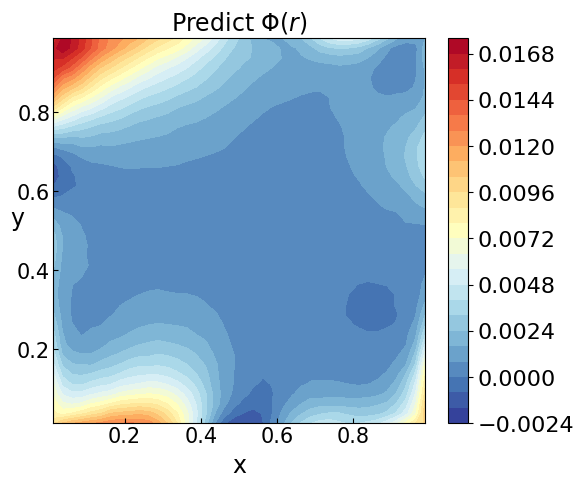

In [10]:
fontdict = {'fontsize': 17, 'fontweight': 'normal'}
plot_contour(X, Y, pre_phi, r"Predict $\Phi(r)$", fontdict, figsize=(6, 5), save_path="pre_phi.pdf")

In [2]:
import os

DATA_PATH = "/root/projects/deeponet/data/g0.1-sigma_a3-sigma_t6_test_normalized.npz"

# 获取文件名和扩展名
filename, ext = os.path.splitext(os.path.basename(DATA_PATH))

In [3]:
filename

'g0.1-sigma_a3-sigma_t6_test_normalized'

In [ ]:
# 获取文件名，不包括扩展名
file_name = filename[:-len(ext)]

print(file_name)